# Benchmark for vibration of a string

Assumptions made:
- string is treated as perfectly flexible (no stiffness)
- fixed-fixed condition so that reflections are perfectly inverted

Goal: simulate the kink resulting from plucking the string

Constituitive equation (wave equation): $\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}$

where,
$
y = displacement\:of\:the\:string\:from\:equilibirum \\
x = position\:along\:the\:string \\
t = time \\
c = \sqrt{\frac{T}{\mu}} = wave\:speed \\
T = tension \\
\mu = mass\:per\:unit\:length \\
$

Citation(s):
$@article\:{giordano1998physics,
  title={The physics of vibrating strings},
  author={Giordano, Nicholas and Gould, Harvey and Tobochnik, Jan}, 
  journal={Computers in Physics}, 
  volume={12},
  number={2}, 
  pages={138--145}, 
  year={1998},
  publisher={American Institute of Physics}
}$

In [1]:
using CombinatorialSpaces, DifferentialEquations, CairoMakie
using Catlab.CategoricalAlgebra
using Plots

# dual subdivision 
function dual(s::EmbeddedDeltaSet1D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex1D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh and boundary conditions

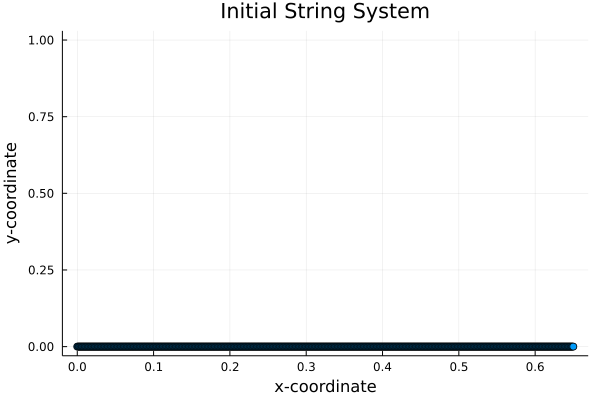

In [2]:
# Define mesh
s2D = EmbeddedDeltaSet2D("meshes/truss.obj")
s = EmbeddedDeltaSet1D{Bool, eltype(s2D[:point])}()

add_vertices!(s, 650, point=[eltype(s2D[:point])(i,0.0,0.0) for i in range(0, 0.65, length=650)])
add_edges!(s, [i for i in 1:(nv(s)-1)], [i+1 for i in 1:(nv(s)-1)], edge_orientation=true)
orient!(s) # for laplacian

sd = dual(s)

# Define vertices for BC application (fixed-fixed)
left = 1
right = nv(s)

# Plot mesh
x_loc = [p[1] for p in s[:point]]
y_loc = [p[2] for p in s[:point]]
Plots.plot(x_loc, y_loc,
     legend=:none, seriestype = :scatter,
     xlabel="x-coordinate",ylabel="y-coordinate",
     title="Initial String System",
     ylims=[minimum(y_loc),0],
     xlims=[minimum(x_loc),maximum(x_loc)])

## Plot initial string pluck distribution

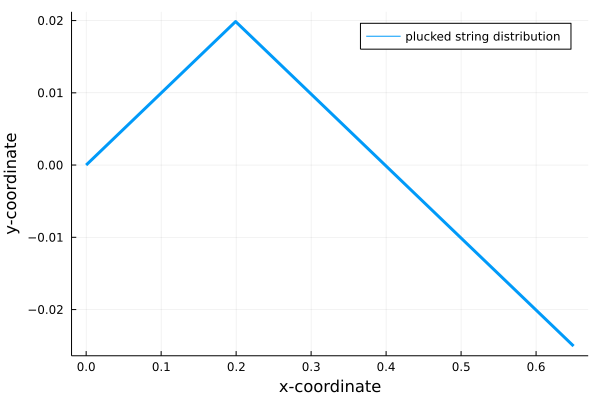

In [3]:
x = VForm([p[1] for p in s[:point]]); # x-location along string
y = VForm([p[2] for p in s[:point]]); # y-location 

a = x[200]
m = a/2
x .= x.data
y.data .= m.* (x .- a) .* sign.(a .- x) .+ m*a

Plots.plot(x, y, 
     label = "plucked string distribution",
     xlabel="x-coordinate", ylabel="y-coordinate",
     linewidth = 3)

## Add the physics

In [14]:
c = 0.2 # wave speed, m/s
g = -0.02 # drag force, N
γ = -1.5 # damping factor, N*s/m

v = VForm(zeros(nv(s))) # y velocity

lapl = ∇²(Val{0}, sd) # initialize the laplacian operator

u0 = vcat(x.data, y.data, v.data) # initial condition for displacement

x_range = 1:length(x)
y_range = (1:length(y)) .+ length(x)
v_range = (1:length(v)) .+ length(x) .+ length(y)

# Physics WITHOUT damping or weighting
vf1(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

# Physics with weighting
vf2(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]) .* (lapl * u[y_range]) .+ p[2] # wave equation with drag
    du[y_range] .= u[v_range]
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

# Physics with damping
vf3(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]) .* (lapl * u[y_range]) 
    du[y_range] .= u[v_range] 
    du[v_range] .+= p[2] .* u[v_range] # add damping
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

# Physics with damping AND weighting
vf4(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]) .* (lapl * u[y_range]) .+ p[2] # wave equation with drag
    du[y_range] .= u[v_range] 
    du[v_range] .+= p[3] .* u[v_range] # add damping
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

vf4 (generic function with 1 method)

## Run the simulation(s)

In [37]:
# WITHOUT damping or weighting
tspan = (0.0,10.0)
prob = ODEProblem(vf1, u0, tspan, [c])
sol1 = solve(prob);

# with weighting
tspan = (0.0,10.0)
prob = ODEProblem(vf2, u0, tspan, [c, g])
sol2 = solve(prob);

# with damping
tspan = (0.0,10.0)
prob = ODEProblem(vf3, u0, tspan, [c, γ])
sol3 = solve(prob);

# with damping AND weighting
tspan = (0.0,10.0)
prob = ODEProblem(vf4, u0, tspan, [c, g, γ])
sol4 = solve(prob);

## Plot results (undamped)

In [47]:
x_loc = [p[1] for p in s[:point]]
y_loc = [sol1(0)[y_range] sol1(1)[y_range] sol1(2)[y_range] sol1(3)[y_range] sol1(4)[y_range] sol1(5)[y_range] sol1(6)[y_range] sol1(7)[y_range] sol1(8)[y_range] sol1(9)[y_range] sol1(10)[y_range]]
Plots.plot(x_loc, y_loc, 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t-8s" "t=9s" "t=10s"],
    xlabel="x-coordinate", ylabel="y-coordinate",
    title="Vibrating String System - Free",
    linewidth = 1.5)

savefig("free_stringVib.png")

## Plot results (damped)

In [49]:
x_loc = [p[1] for p in s[:point]]

Plots.plot(x_loc, 
    [sol2(0)[y_range] sol2(1)[y_range] sol2(2)[y_range] sol2(3)[y_range] sol2(4)[y_range] sol2(5)[y_range] sol2(6)[y_range] sol2(7)[y_range] sol2(8)[y_range] sol2(9)[y_range] sol2(10)[y_range]], 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t=8s" "t=9s" "t=10s"],
    xlabel="x-coordinate",ylabel="y-coordinate",
    title="Vibrating String System - Damped",
    linewidth = 1.5)
show
savefig("damped_stringVib.png")

## Record results 

┌ Info: Saved animation to 
│   fn = C:\Users\mgatlin3\GitHub\AlgebraicDynamics.jl\notebooks\string-unweighted.gif
└ @ Plots C:\Users\mgatlin3\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\mgatlin3\\GitHub\\AlgebraicDynamics.jl\\notebooks\\string-unweighted.gif")
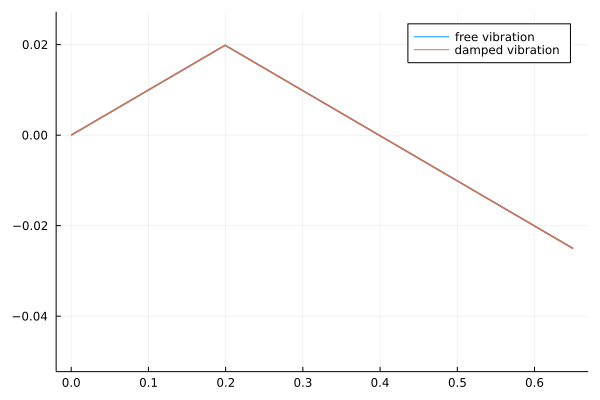

In [43]:
anim = @animate for t ∈ range(0,10.0, length=50)
    x_loc = [p[1] for p in s[:point]]
    y_loc1 = sol1(t)[y_range]
    y_loc3 = sol3(t)[y_range]
    Plots.plot(x_loc, [y_loc1 y_loc3], 
        label = ["free vibration" "damped vibration"],
        ylim = [-0.05, 0.025],
        linewidth = 1.5)
end

gif(anim, "string-unweighted.gif", fps = 5)

## Record results (weighted)

┌ Info: Saved animation to 
│   fn = C:\Users\mgatlin3\GitHub\AlgebraicDynamics.jl\notebooks\string-weighted.gif
└ @ Plots C:\Users\mgatlin3\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\mgatlin3\\GitHub\\AlgebraicDynamics.jl\\notebooks\\string-weighted.gif")
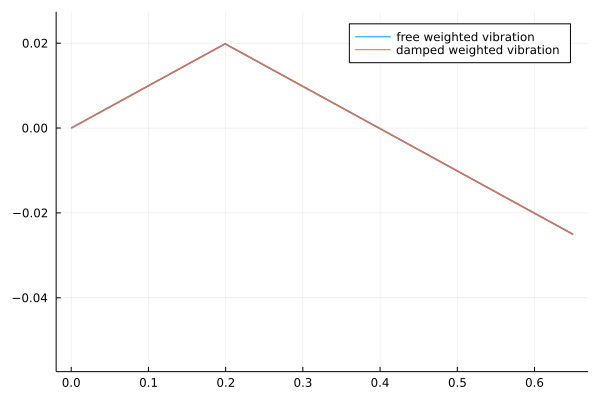

In [42]:
anim = @animate for t ∈ range(0,10.0, length=50)
    x_loc = [p[1] for p in s[:point]]
    y_loc2 = sol2(t)[y_range]
    y_loc4 = sol4(t)[y_range]
    Plots.plot(x_loc, [y_loc2 y_loc4], 
        label = ["free weighted vibration" "damped weighted vibration"],
        linewidth = 1.5,
        ylims= [-0.055, 0.025])
end

gif(anim, "string-weighted.gif", fps = 5)